In [1]:
from sklearn.tree import DecisionTreeClassifier
from itertools import product
from PIL import Image
import gdal
import numpy as np
import matplotlib.pyplot as plot
from gdalconst import*
from osgeo import ogr
import numpy as np
from sklearn import metrics
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import random
from collections import Counter
from sklearn.datasets import make_classification

In [2]:
#4 creating variables for band files taken from the landscape file of 2012
#4 bands include - Elevation, Aspect, Slope, Fuel Model Number

#year 2012
band1_12 = '/home/skhatter/exp1/us_130lcp13/band1_.tif'
band2_12 = '/home/skhatter/exp1/us_130lcp13/band2_.tif'
band3_12 = '/home/skhatter/exp1/us_130lcp13/band3_.tif'
band4_12 = '/home/skhatter/exp1/us_130lcp13/band4_.tif'

#this file has cumulative fire frequencies from 1992 - 2012
fireFreq = '/home/skhatter/exp2/summation/fire92_12_.tif'


#opening all the band files using gdal
dataset1_12 = gdal.Open(band1_12, GA_ReadOnly)
dataset2_12 = gdal.Open(band2_12, GA_ReadOnly)
dataset3_12 = gdal.Open(band3_12, GA_ReadOnly)
dataset4_12 = gdal.Open(band4_12, GA_ReadOnly)
dataset_fireFreq = gdal.Open(fireFreq, GA_ReadOnly)

In [3]:
#getting individual bands for 2012
band_fireFreq = dataset_fireFreq.GetRasterBand(1)
band1_12 = dataset1_12.GetRasterBand(1)
band2_12 = dataset2_12.GetRasterBand(1)
band3_12 = dataset3_12.GetRasterBand(1)
band4_12 = dataset4_12.GetRasterBand(1)

#get data in the numpy arrays for 2012
data_fireFreq =  np.array(band_fireFreq.ReadAsArray(0,0,band_fireFreq.XSize, band_fireFreq.YSize)) 
data1_12 = np.array(band1_12.ReadAsArray(0,0,band1_12.XSize, band2_12.YSize))
data2_12 = np.array(band2_12.ReadAsArray(0,0,band2_12.XSize, band2_12.YSize))
data3_12 = np.array(band3_12.ReadAsArray(0,0,band3_12.XSize, band3_12.YSize))
data4_12 = np.array(band4_12.ReadAsArray(0,0,band4_12.XSize, band4_12.YSize))

print(data1_12.shape)

(1554, 3002)


In [4]:
#Flattening the arrays

data1_12 = np.reshape(data1_12, data1_12.size)
data2_12 = np.reshape(data2_12, data2_12.size)
data3_12 = np.reshape(data3_12, data3_12.size)
data4_12 = np.reshape(data4_12, data4_12.size)
data_fireFreq = np.reshape(data_fireFreq, data_fireFreq.size)

In [5]:
#Creating variables for Fire Parameters

#file for 2013-14 - this file has 1/0 if the fire happened in 2013-2014/ or not
fireParamFile_14 = '/home/skhatter/exp1/fire2014/fire2014_.tif'


#opening the files using gdal
fireDataset_14 = gdal.Open(fireParamFile_14, GA_ReadOnly)


#getting the raster band 1 from all the 4 datasets
fireBand1_14 = fireDataset_14.GetRasterBand(1)


#converting the rasterized values in arrays
data5_14 =  np.array(fireBand1_14.ReadAsArray(0,0,fireBand1_14.XSize, fireBand1_14.YSize))

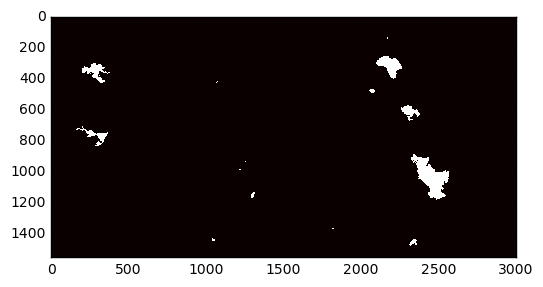

In [6]:
#Plotting the fire band
a = data5_14
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [7]:
#Flattening the fire14 band
data5_14 = np.reshape(data5_14, data5_14.size)
print(data5_14.shape)

(4665108,)


In [8]:
#creating feature vector using complete data
#5 FEATURES-  Fire Frequency, Elevation, Slope, Aspect, Fuel Model Number
data_t = []
data_t.append(data_fireFreq)
data_t.append(data1_12)
data_t.append(data2_12)
data_t.append(data3_12)
data_t.append(data4_12)
data = np.array(data_t)
print(data.shape)
data = data.T

#feature vector is X
X = data

#target vector is y
y = data5_14

print(X.shape)

print('Original dataset Shape {}'.format(Counter(y)))

(5, 4665108)
(4665108, 5)
Original dataset Shape Counter({0.0: 4596878, 1.0: 68230})


In [9]:
#creating test set and training set  using train_test_split
#Split arrays or matrices into random train and test subsets in ratios 80:20
#indices are used so as to trace the coordinates
X_indices = []
X_indices = list(range(y.shape[0]))
X_indices = np.asarray(X_indices)
X_train = []
X_test = []
X_test_map = np.zeros(shape=(a.shape[0], a.shape[1]))


X_indices_train, X_indices_test, y_train, y_test = train_test_split(X_indices, y, test_size = 0.2, stratify = y)

for i in range(len(X_indices_train)):
    X_train.append(data[X_indices_train[i]])


X_train = np.asarray(X_train)
    
for i in range(len(X_indices_test)):
    r = X_indices_test[i]//a.shape[1]
    c = X_indices_test[i] - r*a.shape[1]
    X_test.append(data[X_indices_test[i]])
    if y_test[i] == 1:
        X_test_map[r][c] = 1
      

    
    
X_test = np.asarray(X_test)
print(X_train.shape)
print(X_test.shape)

(3732086, 5)
(933022, 5)


In [10]:
#creating original classifier
classifier_original = DecisionTreeClassifier(random_state=42)

In [11]:
#fitting the data in the classifier
classifier_original = classifier_original.fit(X_train, y_train)

In [12]:
from sklearn.metrics import roc_curve, auc

#finding prediction for class 0 that is class Non-Burnt
y_pred_prob_1 = classifier_original.predict_proba(X_test)[:,1]
false_positive_rate_1, true_positive_rate_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1, pos_label = 1)
roc_auc_1 = auc(false_positive_rate_1, true_positive_rate_1)

In [13]:
#Solving Class Imbalance problem using- SMOTE
from imblearn.over_sampling import SMOTE

#fitting the training set on SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_sample(X_train, y_train)

print('Resampled shape of the training set after applying SMOTE {}'.format(Counter(y_smote)))

#Fitting the smote'd samples on classifier_original
classifier_smote = DecisionTreeClassifier(random_state=42).fit(X_smote, y_smote)

Resampled shape of the training set after applying SMOTE Counter({0.0: 3677502, 1.0: 3677502})


In [14]:
y_pred_prob_2 = classifier_smote.predict_proba(X_test)[:,1]
false_positive_rate_2, true_positive_rate_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2, pos_label = 1)
roc_auc_2 = auc(false_positive_rate_2, true_positive_rate_2)

In [15]:
#Solving Class Imbalance problem using- SMOTEEN
from imblearn.combine import SMOTEENN 

smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_sample(X_train, y_train)
print('Resampled shape of the training set after applying SMOTE {}'.format(Counter(y_smoteenn)))

#Fitting the smote'd samples on classifier_original
classifier_smoteenn = DecisionTreeClassifier(random_state=42).fit(X_smoteenn, y_smoteenn)

Resampled shape of the training set after applying SMOTE Counter({0.0: 3677502, 1.0: 3583607})


In [16]:
y_pred_prob_3 = classifier_smoteenn.predict_proba(X_test)[:,1]
false_positive_rate_3, true_positive_rate_3, thresholds_3 = roc_curve(y_test, y_pred_prob_3, pos_label = 1)
roc_auc_3 = auc(false_positive_rate_3, true_positive_rate_3)

In [17]:
#Solving Class Imbalance problem using- SMOTE+Tomek
from imblearn.combine import SMOTETomek 

smotetomek = SMOTETomek(random_state=42)
X_smotetomek, y_smotetomek = smotetomek.fit_sample(X_train, y_train)

#Fitting the smote'd samples on classifier_original
classifier_smotetomek = DecisionTreeClassifier(random_state=42).fit(X_smotetomek, y_smotetomek)

In [18]:
y_pred_prob_4 = classifier_smotetomek.predict_proba(X_test)[:,1]
false_positive_rate_4, true_positive_rate_4, thresholds_4 = roc_curve(y_test, y_pred_prob_4, pos_label = 1)
roc_auc_4 = auc(false_positive_rate_4, true_positive_rate_4)

In [19]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_sample(X_train, y_train)

classifier_randomunder = DecisionTreeClassifier(random_state=42).fit(X_rus, y_rus)

In [20]:
y_pred_prob_5 = classifier_randomunder.predict_proba(X_test)[:,1]
false_positive_rate_5, true_positive_rate_5, thresholds_5 = roc_curve(y_test, y_pred_prob_5, pos_label = 1)
roc_auc_5 = auc(false_positive_rate_5, true_positive_rate_5)

In [21]:
# using logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg = logreg.fit(X_rus, y_rus)

In [22]:
y_pred_prob_6 = logreg.predict_proba(X_test)[:,1]
false_positive_rate_6, true_positive_rate_6, thresholds_6 = roc_curve(y_test, y_pred_prob_6, pos_label = 1)
roc_auc_6 = auc(false_positive_rate_6, true_positive_rate_6)

In [23]:
#Using SGDClassifier with 'log' loss
from sklearn.linear_model import SGDClassifier

sgdClassifier = SGDClassifier(random_state=42, loss = 'log')
sgdClassifier = sgdClassifier.fit(X_rus, y_rus)

In [24]:
y_pred_prob_7 = sgdClassifier.predict_proba(X_test)[:,1]
false_positive_rate_7, true_positive_rate_7, thresholds_7 = roc_curve(y_test, y_pred_prob_7, pos_label = 1)
roc_auc_7 = auc(false_positive_rate_7, true_positive_rate_7)

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


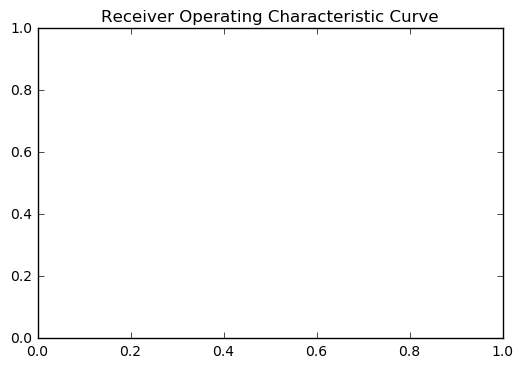

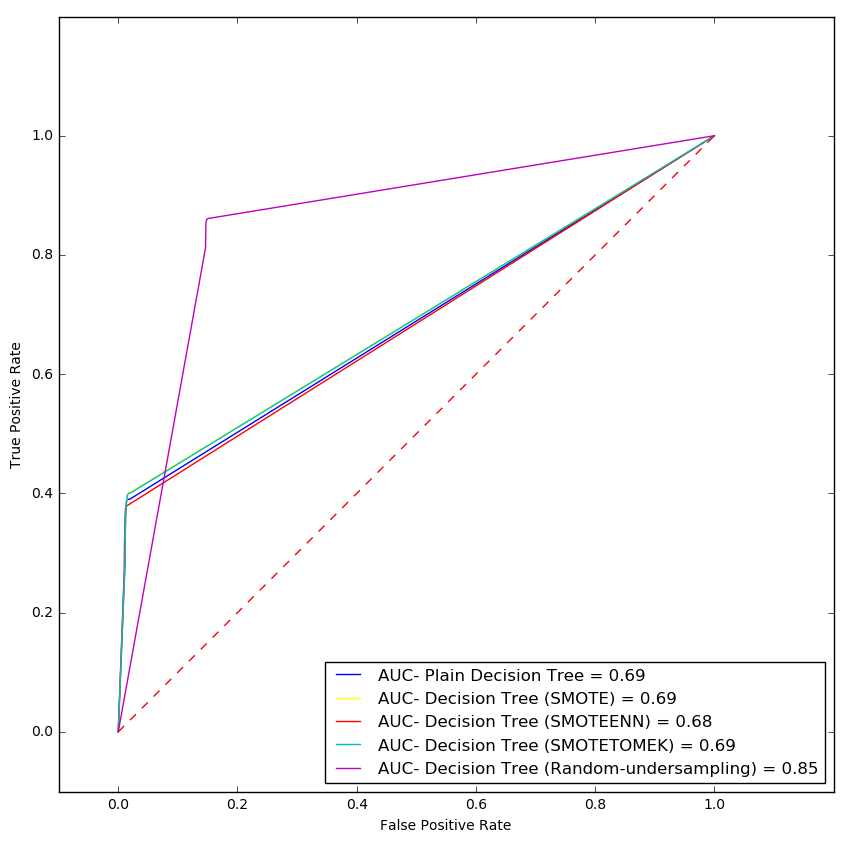

In [25]:
plt.title('Receiver Operating Characteristic Curve')
plt.figure(figsize=(10,10))
plt.plot(false_positive_rate_1, true_positive_rate_1, 'b',label='AUC- Plain Decision Tree = %0.2f'% roc_auc_1)
plt.plot(false_positive_rate_2, true_positive_rate_2, 'yellow',label='AUC- Decision Tree (SMOTE) = %0.2f'% roc_auc_2)
plt.plot(false_positive_rate_3, true_positive_rate_3, 'r',label='AUC- Decision Tree (SMOTEENN) = %0.2f'% roc_auc_3)
plt.plot(false_positive_rate_4, true_positive_rate_4, 'c',label='AUC- Decision Tree (SMOTETOMEK) = %0.2f'% roc_auc_4)
plt.plot(false_positive_rate_5, true_positive_rate_5, 'm',label='AUC- Decision Tree (Random-undersampling) = %0.2f'% roc_auc_5)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
#Using tuned decision tree classifier

decision_tree_tuned = DecisionTreeClassifier(random_state=42, max_features = 4, max_depth = 20, min_samples_split= 50, min_samples_leaf = 10, criterion = "gini")
decision_tree_tuned = decision_tree_tuned.fit(X_rus, y_rus)

In [28]:
y_pred_prob_8 = decision_tree_tuned.predict_proba(X_test)[:,1]
false_positive_rate_8, true_positive_rate_8, thresholds_8 = roc_curve(y_test, y_pred_prob_8, pos_label = 1)
roc_auc_8 = auc(false_positive_rate_8, true_positive_rate_8)

In [29]:
#Using Random Forest
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(random_state=42).fit(X_rus, y_rus)

In [30]:
y_pred_prob_9 = randomForest.predict_proba(X_test)[:,1]
false_positive_rate_9, true_positive_rate_9, thresholds_9 = roc_curve(y_test, y_pred_prob_9, pos_label = 1)
roc_auc_9 = auc(false_positive_rate_9, true_positive_rate_9)

In [31]:
randomForest_tuned = RandomForestClassifier(random_state=42, n_estimators = 100).fit(X_rus, y_rus)

In [32]:
y_pred_prob_10 = randomForest_tuned.predict_proba(X_test)[:,1]
false_positive_rate_10, true_positive_rate_10, thresholds_10 = roc_curve(y_test, y_pred_prob_10, pos_label = 1)
roc_auc_10 = auc(false_positive_rate_10, true_positive_rate_10)

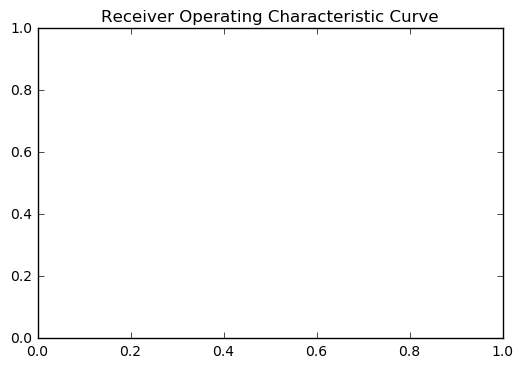

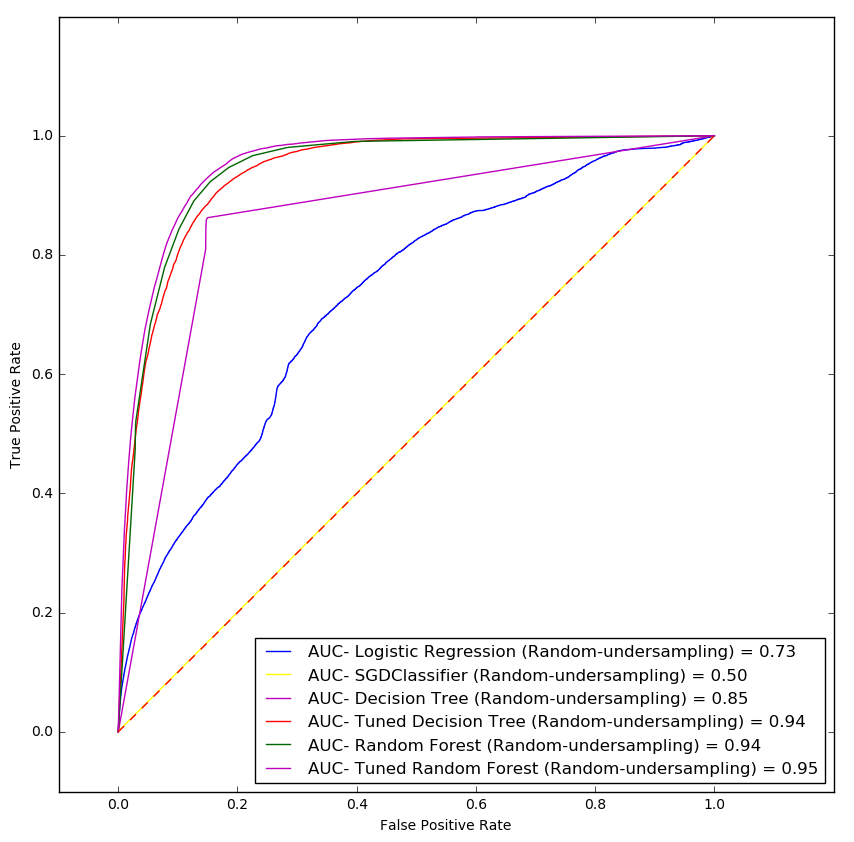

In [49]:
plt.title('Receiver Operating Characteristic Curve')
plt.figure(figsize=(10,10))
plt.plot(false_positive_rate_6, true_positive_rate_6, 'b',label='AUC- Logistic Regression (Random-undersampling) = %0.2f'% roc_auc_6)
plt.plot(false_positive_rate_7, true_positive_rate_7, 'yellow',label='AUC- SGDClassifier (Random-undersampling) = %0.2f'% roc_auc_7)
plt.plot(false_positive_rate_5, true_positive_rate_5, 'm',label='AUC- Decision Tree (Random-undersampling) = %0.2f'% roc_auc_5)
plt.plot(false_positive_rate_8, true_positive_rate_8, 'r',label='AUC- Tuned Decision Tree (Random-undersampling) = %0.2f'% roc_auc_8)
plt.plot(false_positive_rate_9, true_positive_rate_9, 'darkgreen',label='AUC- Random Forest (Random-undersampling) = %0.2f'% roc_auc_9)
plt.plot(false_positive_rate_10, true_positive_rate_10, 'm',label='AUC- Tuned Random Forest (Random-undersampling) = %0.2f'% roc_auc_10)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()